## initial mapping workflow for supratidal forests (STF)
- works on geojson from http://geojson.io (add add 'field' with value 1)
- select 'time_range' and if to 'export' results as tif

In [1]:
import time

start = time.time()

In [2]:
%matplotlib inline

import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(1, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map #, map_shapefile
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
dc = datacube.Datacube()

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

### user inputs: geojson AOI, time, export geotiffs?

In [3]:
## vector file created from https://geojson.io/ and adding a new column in table called field and value of 1
# vector_file = '../National_EEA/tomago.geojson'
# attribute_col = 'field'

# vector_file = '../National_EEA/trinity_inlet.geojson'
# attribute_col = 'field'

# vector_file = './geojson/cairns.geojson'
# attribute_col = 'field'

# vector_file = './geojson/hunter.geojson'
# attribute_col = 'field'

# vector_file = './geojson/minnamurra.geojson'
# attribute_col = 'field'

# vector_file = './geojson/shoalhaven.geojson'
# attribute_col = 'field'

# vector_file = './geojson/westernport.geojson'
# attribute_col = 'field'

vector_file = './geojson/maryriver.geojson'
attribute_col = 'field'

#vector_file = './geojson/ga_summary_grid_c3_coastal.geojson'
#attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)

# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

In [3]:
#mainland_grid = gdf[gdf['type'] == 'mainland']

In [4]:
id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
print(id_list)

NameError: name 'mainland_grid' is not defined

In [58]:
mainland_grid

,region_code,ix,iy,utc_offset,id,type,geometry
11,x27y44,27,44,9,12,mainland,"POLYGON ((131.14236 -10.95979, 131.13657 -11.8..."
12,x28y44,28,44,9,13,mainland,"POLYGON ((132.00000 -10.96278, 132.00000 -11.8..."
13,x29y44,29,44,9,14,mainland,"POLYGON ((132.85764 -10.95979, 132.86343 -11.8..."
14,x30y44,30,44,9,15,mainland,"POLYGON ((133.71520 -10.95084, 133.72679 -11.8..."
18,x39y44,39,44,9,19,mainland,"POLYGON ((141.41707 -10.60201, 141.48049 -11.4..."
...,...,...,...,...,...,...,...
317,x40y07,40,7,10,318,mainland,"POLYGON ((145.64093 -42.46921, 145.76292 -43.3..."
318,x41y07,41,7,10,319,mainland,"POLYGON ((146.76796 -42.37058, 146.89986 -43.2..."
319,x42y07,42,7,10,320,mainland,"POLYGON ((147.89269 -42.26423, 148.03442 -43.1..."
320,x40y06,40,6,10,321,mainland,"POLYGON ((145.76292 -43.35558, 145.88711 -44.2..."


In [59]:
#gdf = mainland_grid.loc[mainland_grid['id'] == 26]

In [5]:
#map_shapefile(gdf, attribute=attribute_col)
gdf.explore(basemap=imagery)

NameError: name 'imagery' is not defined

In [6]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

In [7]:
'''# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})
'''
# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

### load strm, item, mangroves

In [ ]:
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h

# Load item
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative

# Load in mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

### load in woody cover virtual product

In [63]:
# load in vp woody cover
sys.path.insert(1, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

VirtualProductException: name best_pixel_gmad under aggregate is already registered

In [64]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

VirtualProductException: name woody_cover under transform is already registered

In [65]:
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, **query)

# # woody cover with threshold for saltmarsh
woody_cover = xr.where(woody_cover_vp.woody_cover > 0.5, 1, 0).astype('int8')
woody_cover.attrs['crs'] = 'EPSG:3577'

/env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### create initial supratidal forest extent product

In [66]:
## wrangle binary maps and create STF mask

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# greater than 1m AHD and less than 10m AHD == True
AHD_min = 1
AHD_max = 10

# SRTM
lessthan10m_AHD = srtm <= AHD_max
greaterthan1m_AHD = srtm >= AHD_min
AHD_threshold_srtm = lessthan10m_AHD & greaterthan1m_AHD

# item (remove all intertidal areas)
not_intertidal = item == 9

# remove time dim
not_mangrove = not_mangrove.squeeze('time')
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

In [67]:
# combine masks
STF = xr.where((woody_cover == False) + (not_mangrove == False) + (AHD_threshold_srtm == False) + (not_intertidal == False), 0, 1).astype('int8')

In [68]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
STF = STF.where(mask)

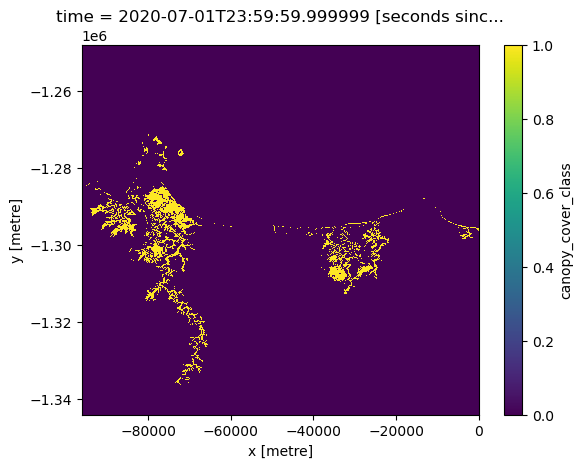

In [69]:
mangrove.plot()

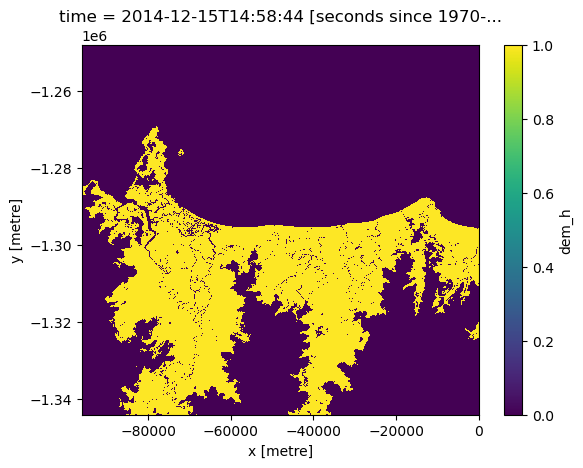

In [70]:
AHD_threshold_srtm.plot()

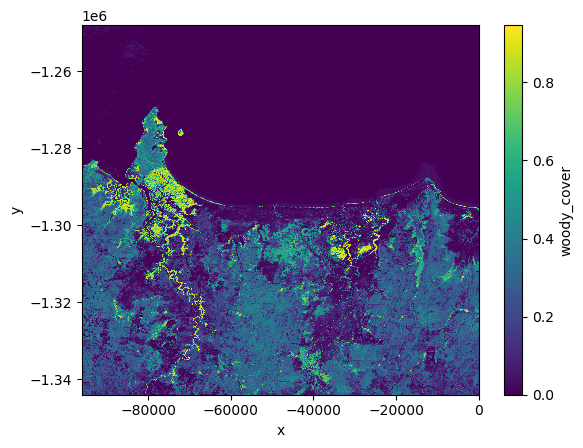

In [71]:
woody_cover_vp.woody_cover.plot()

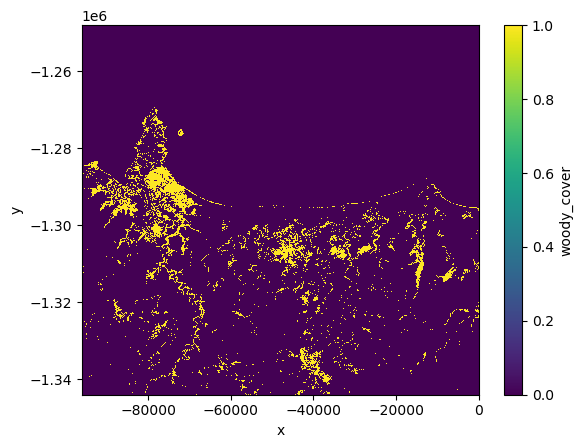

In [72]:
woody_cover.plot()

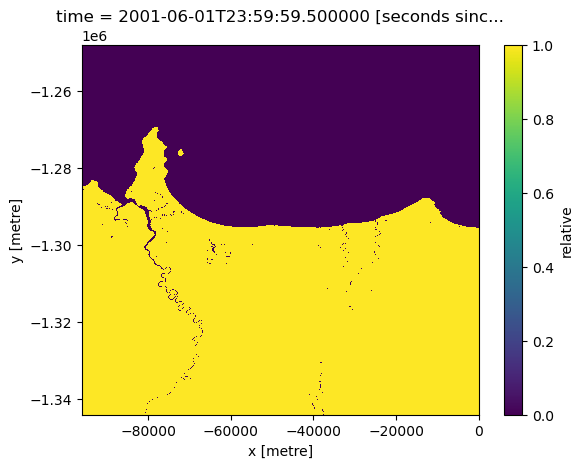

In [73]:
not_intertidal.plot()

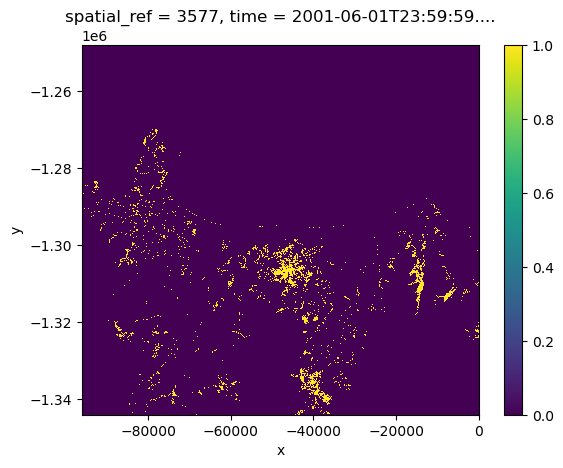

In [75]:
STF.plot()

### combine inputs and output to 5 band geotiff

In [76]:
mangrove_ds = mangrove.to_dataset(name="mangrove").squeeze().drop('time')
AHD_threshold_srtm_ds = AHD_threshold_srtm.to_dataset(name="AHD_threshold_srtm").squeeze().drop('time')
woody_cover_ds = woody_cover.to_dataset(name="woody_cover").squeeze()
not_intertidal_ds = not_intertidal.to_dataset(name="not_intertidal").squeeze().drop('time')
STF_ds = STF.to_dataset(name="STF").squeeze().drop('time')


In [77]:
variables_xarray_list = []
variables_xarray_list.append(mangrove_ds)
variables_xarray_list.append(AHD_threshold_srtm_ds)
variables_xarray_list.append(woody_cover_ds)
variables_xarray_list.append(not_intertidal_ds)
variables_xarray_list.append(STF_ds)
export_geotiff = xr.merge(variables_xarray_list)

In [78]:
export_geotiff

<xarray.Dataset>
Dimensions:             (y: 3201, x: 3200)
Coordinates:
  * y                   (y) float64 -1.344e+06 -1.344e+06 ... -1.248e+06
  * x                   (x) float64 -9.598e+04 -9.596e+04 ... -45.0 -15.0
    spatial_ref         int32 3577
Data variables:
    mangrove            (y, x) bool False False False ... False False False
    AHD_threshold_srtm  (y, x) bool False False False ... False False False
    woody_cover         (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    not_intertidal      (y, x) bool True True True True ... False False False
    STF                 (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [80]:
# Write GeoTIFF
write_cog(geo_im=export_geotiff.to_array(),
          fname='export_geotiff_26.tif',
          overwrite=True)

PosixPath('export_geotiff_26.tif')

In [81]:
from osgeo import gdal
def set_band_names(input_img: str, band_names: list, feedback: bool = False):
    """
    A utility function to set band names.

    :param input_img: input image file.
    :param band_names: is a list of band names
    :param feedback: is a boolean specifying whether feedback will be printed to the
                     console (True= Printed / False (default) Not Printed)

    .. code:: python

        from rsgislib import imageutils

        input_img = 'injune_p142_casi_sub_utm.kea'
        band_names = ['446nm','530nm','549nm','569nm','598nm','633nm','680nm','696nm',
                      '714nm','732nm','741nm','752nm','800nm','838nm']

        imageutils.set_band_names(input_img, band_names)

    """
    dataset = gdal.Open(input_img, gdal.GA_Update)

    for i in range(len(band_names)):
        band = i + 1
        bandName = band_names[i]

        imgBand = dataset.GetRasterBand(band)
        # Check the image band is available
        if not imgBand is None:
            if feedback:
                print('Setting Band {0} to "{1}"'.format(band, bandName))
            imgBand.SetDescription(bandName)
        else:
            raise rsgislib.RSGISPyException("Could not open the image band: ", band)


In [82]:
input_img = './export_geotiff_26.tif'
band_names = ['mangrove','AHD_threshold_srtm','woody_cover','not_intertidal','STF']

set_band_names(input_img, band_names)

### output to geotiff

In [83]:
# STF (1 = STF, 0 = not STF)
if export == False:
    pass
else:
    write_cog(geo_im=STF.astype('int8'),
              fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + gdf['id'].astype(str).item() +'_STF_' + time_range[0] + '.tif', # first part gets AOI name
              overwrite=True,
              nodata=0.0)

In [84]:
end = time.time()
elapsed_time = end - start
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"Elapsed time: {minutes} minutes and {seconds:.2f} seconds")

Elapsed time: 8 minutes and 5.83 seconds
